# Oil Well Placement Using Predictive Modeling and Risk Analysis


## Project description

You work for the OilyGiant mining company. Your task is to find the best place for a new well.

Steps to choose the location:

    - Collect the oil well parameters in the selected region: oil quality and volume of reserves;
    - Build a model for predicting the volume of reserves in the new wells;
    - Pick the oil wells with the highest estimated values;
    - Pick the region with the highest total profit for the selected oil wells.

You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.

### Goal
- Build a model that will help to pick the region with the highest profit margin to suggest that region for development of oil wells and justify why.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


## Load and Prepare Data

In [2]:
# Load the datasets for the three regions
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

# Display the first few rows of each dataset
geo_data_0.head(), geo_data_1.head(), geo_data_2.head()


(      id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647
 3  iJLyR -0.032172  0.139033  2.978566  168.620776
 4  Xdl7t  1.988431  0.155413  4.751769  154.036647,
       id         f0         f1        f2     product
 0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1  62mP7  14.272088  -3.475083  0.999183   26.953261
 2  vyE1P   6.263187  -5.948386  5.001160  134.766305
 3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
 4  AHL4O  12.702195  -8.147433  5.004363  134.766305,
       id        f0        f1        f2     product
 0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
 1  WJtFt  0.262778  0.269839 -2.530187   56.069697
 2  ovLUW  0.194587  0.289035 -5.586433   62.871910
 3  q6cA6  2.236060 -0.553760  0.930038  114.572842
 4  WPMUX -0.515993  1.716266  5.899011  149.600746)

In [3]:
# Function to check for column-wise duplicates, including 'id'
def check_column_duplicates(data, region_name):
    print(f"--- {region_name}: Column-wise Duplicate Check ---")
    
    # Check for duplicates in each column
    for column in data.columns:
        duplicate_count = data[column].duplicated().sum()
        if duplicate_count > 0:
            print(f"Column '{column}' has {duplicate_count} duplicate values.")
        else:
            print(f"Column '{column}' has no duplicate values.")
    
    print("\n")

# Check for duplicates in columns for each region, including 'id'
check_column_duplicates(geo_data_0, "Region 0")
check_column_duplicates(geo_data_1, "Region 1")
check_column_duplicates(geo_data_2, "Region 2")



--- Region 0: Column-wise Duplicate Check ---
Column 'id' has 10 duplicate values.
Column 'f0' has no duplicate values.
Column 'f1' has no duplicate values.
Column 'f2' has no duplicate values.
Column 'product' has no duplicate values.


--- Region 1: Column-wise Duplicate Check ---
Column 'id' has 4 duplicate values.
Column 'f0' has no duplicate values.
Column 'f1' has no duplicate values.
Column 'f2' has no duplicate values.
Column 'product' has 99988 duplicate values.


--- Region 2: Column-wise Duplicate Check ---
Column 'id' has 4 duplicate values.
Column 'f0' has no duplicate values.
Column 'f1' has no duplicate values.
Column 'f2' has no duplicate values.
Column 'product' has no duplicate values.




In [4]:
# Investigate unique values in the 'product' column in Region 1
unique_products_region_1 = geo_data_1['product'].value_counts()
print(unique_products_region_1)


53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64


In [5]:
# Function to investigate duplicates based on 'id'
def investigate_id_duplicates(data, region_name):
    duplicate_ids = data[data['id'].duplicated(keep=False)]
    print(f"--- {region_name}: Investigating Duplicate 'id' Rows ---")
    return duplicate_ids

# Investigate duplicate 'id' rows for each region
duplicate_rows_region_0 = investigate_id_duplicates(geo_data_0, "Region 0")
duplicate_rows_region_1 = investigate_id_duplicates(geo_data_1, "Region 1")
duplicate_rows_region_2 = investigate_id_duplicates(geo_data_2, "Region 2")

# Display the duplicate rows to see if they are identical or different
duplicate_rows_region_0, duplicate_rows_region_1, duplicate_rows_region_2


--- Region 0: Investigating Duplicate 'id' Rows ---
--- Region 1: Investigating Duplicate 'id' Rows ---
--- Region 2: Investigating Duplicate 'id' Rows ---


(          id        f0        f1         f2     product
 931    HZww2  0.755284  0.368511   1.863211   30.681774
 1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
 1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
 3389   A5aEY -0.039949  0.156872   0.209861   89.249364
 7530   HZww2  1.061194 -0.373969  10.430210  158.828695
 16633  fiKDv  0.157341  1.028359   5.585586   95.817889
 21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
 41724  bxg6G -0.823752  0.546319   3.630479   93.007798
 42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
 51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
 60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
 63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
 64022  74z30  0.741456  0.459229   5.153109  140.771492
 66136  74z30  1.084962 -0.312358   6.990771  127.643327
 69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
 75715  Tdehs  0.112079  0.430296   3.218993   60.964018
 89582  bsk9y  0.398908 -0.4002

In [6]:
# Function to check for missing values and duplicates in each dataset
def check_data_quality(data, region_name):
    print(f"--- {region_name} ---")
    
    # Check for missing values
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(f"Missing Values:\n{missing_values}\n")
    else:
        print("No missing values found.\n")
    
    # Check for duplicates
    duplicate_rows = data.duplicated().sum()
    if duplicate_rows > 0:
        print(f"Duplicate rows: {duplicate_rows}")
        # Drop duplicates if found
        data = data.drop_duplicates().reset_index(drop=True)
        print("Duplicates removed.\n")
    else:
        print("No duplicates found.\n")
    
    return data

# Check data quality for each region
geo_data_0 = check_data_quality(geo_data_0, "Region 0")
geo_data_1 = check_data_quality(geo_data_1, "Region 1")
geo_data_2 = check_data_quality(geo_data_2, "Region 2")


--- Region 0 ---
No missing values found.

No duplicates found.

--- Region 1 ---
No missing values found.

No duplicates found.

--- Region 2 ---
No missing values found.

No duplicates found.



In [7]:
# Remove the duplicate well IDs
geo_data_0 = geo_data_0.drop_duplicates(subset='id')
geo_data_1 = geo_data_1.drop_duplicates(subset='id')
geo_data_2 = geo_data_2.drop_duplicates(subset='id')


In [8]:
# Final data summary after cleaning
print("Data Summary After Cleaning:")
print("Region 0: ", geo_data_0.info())
print("Region 1: ", geo_data_1.info())
print("Region 2: ", geo_data_2.info())


Data Summary After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
Region 0:  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
Region 1:  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data column

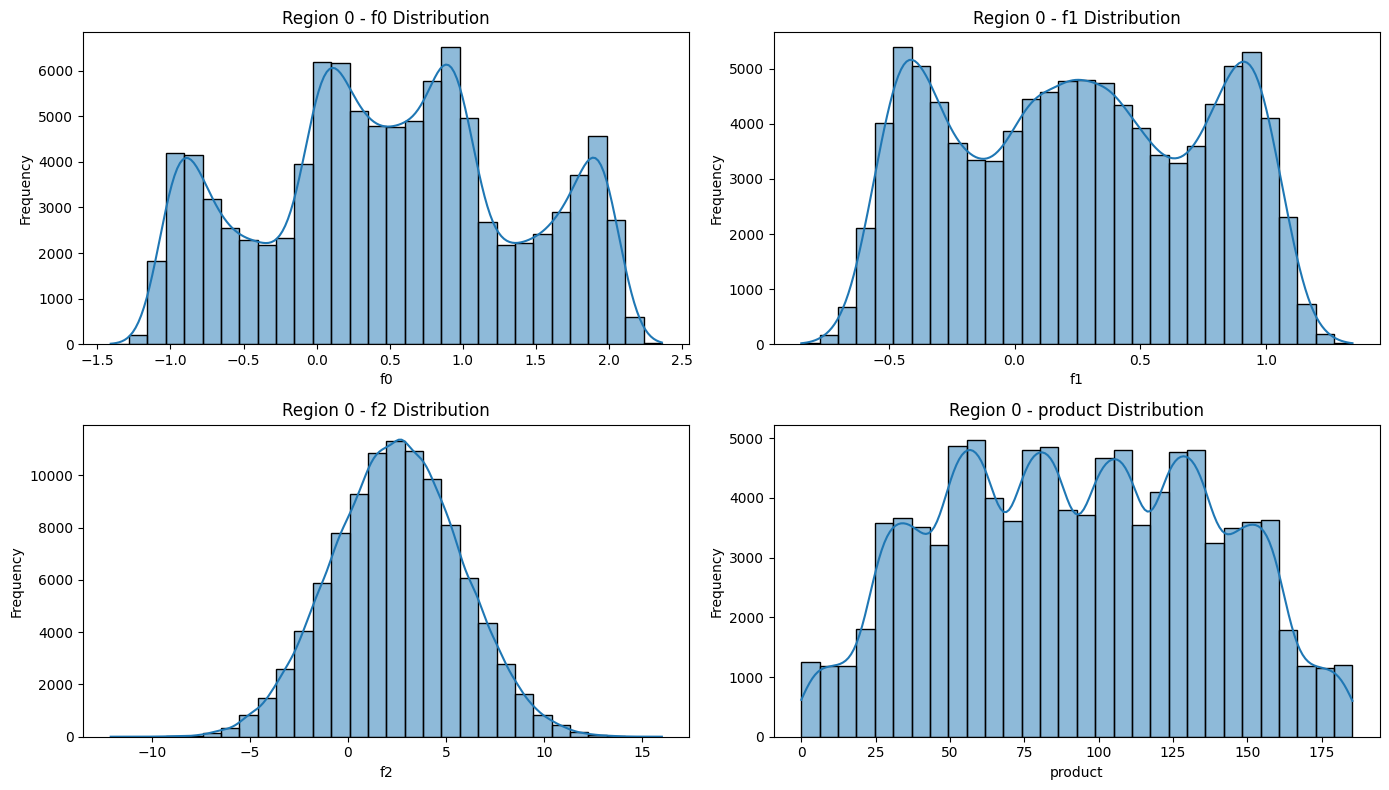

In [9]:
# Function to plot distributions for each feature
def plot_distributions(data, region_name):
    features = ['f0', 'f1', 'f2', 'product']
    plt.figure(figsize=(14, 8))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 2, i)
        sns.histplot(data[feature], bins=30, kde=True)
        plt.title(f'{region_name} - {feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for each region
plot_distributions(geo_data_0, "Region 0")

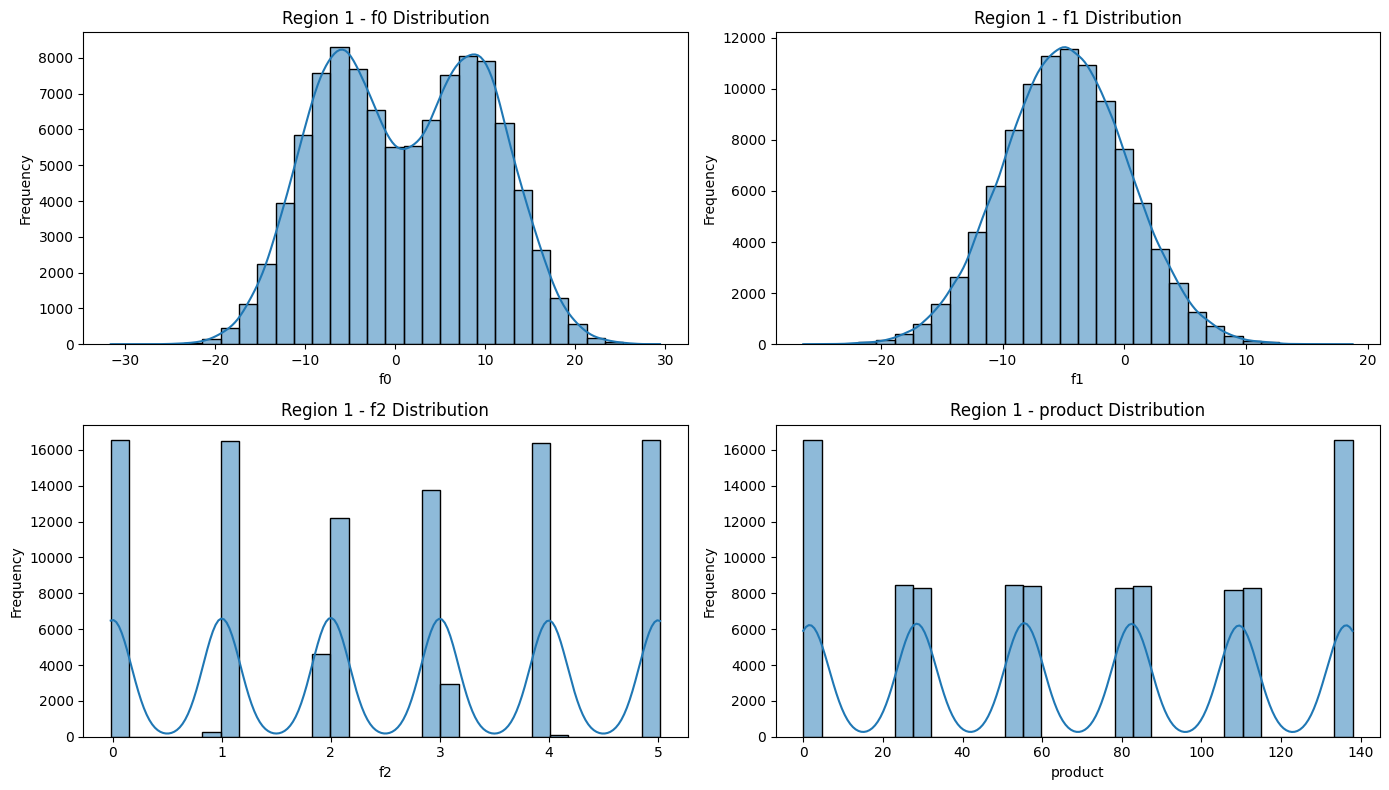

In [10]:
plot_distributions(geo_data_1, "Region 1")

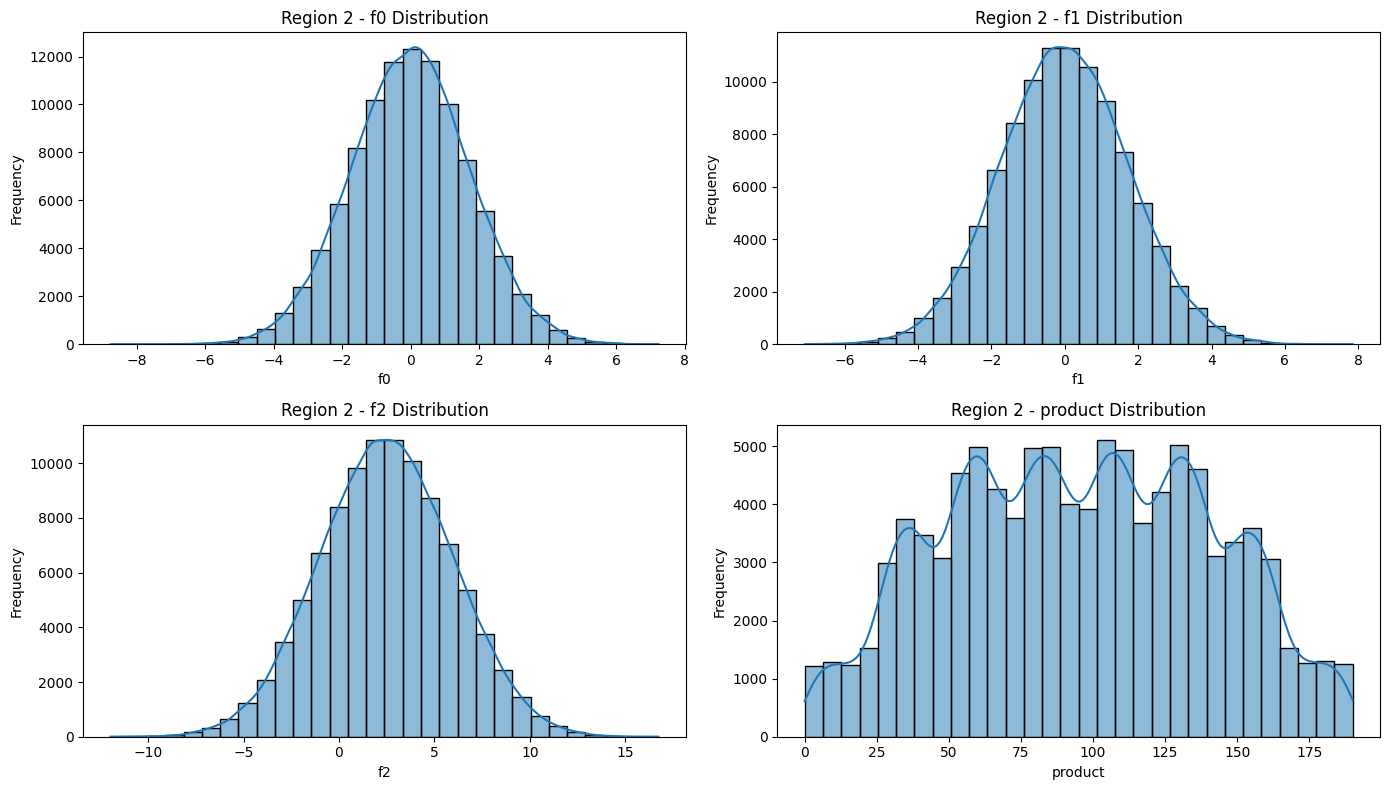

In [11]:
plot_distributions(geo_data_2, "Region 2")

### Observation

- The result shows that there are 12 unique product values in Region 1, with many wells having the same values.
- This is unusual because oil well reserves are typically expected to vary more than this. However, it could be due to a simplification in the synthetic data. Since the values are not completely uniform and there is some variance, we can proceed with the data.

- In each region, we see that some rows with the same id have different values for features (f0, f1, f2) and product.
- Since the features and product values differ, we will not simply drop one of the duplicate rows.

## Train and test the model for each region

In [12]:
# Function to train and evaluate the model for each region
def train_and_evaluate(data):
    X = data.drop(['product', 'id'], axis=1)  # Features
    y = data['product']  # Target (product)
    
    # Split the data into training (75%) and validation (25%)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_valid_scaled)
    
    # Calculate RMSE for the model
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    # Return the model, predictions, actual values, RMSE, and average reserves
    return model, y_pred, y_valid, rmse, y_valid.mean()

# Train and evaluate the model for each region
model_0, y_0_pred, y_0_valid, rmse_0, avg_reserves_0 = train_and_evaluate(geo_data_0)
model_1, y_1_pred, y_1_valid, rmse_1, avg_reserves_1 = train_and_evaluate(geo_data_1)
model_2, y_2_pred, y_2_valid, rmse_2, avg_reserves_2 = train_and_evaluate(geo_data_2)

# Print RMSE and average predicted and actual reserves for each region
print(f"Region 0 - RMSE: {rmse_0:.2f}, Avg Predicted Reserves: {y_0_pred.mean():.2f}, Avg Actual Reserves: {avg_reserves_0:.2f}")
print(f"Region 1 - RMSE: {rmse_1:.2f}, Avg Predicted Reserves: {y_1_pred.mean():.2f}, Avg Actual Reserves: {avg_reserves_1:.2f}")
print(f"Region 2 - RMSE: {rmse_2:.2f}, Avg Predicted Reserves: {y_2_pred.mean():.2f}, Avg Actual Reserves: {avg_reserves_2:.2f}")

Region 0 - RMSE: 37.69, Avg Predicted Reserves: 92.61, Avg Actual Reserves: 92.39
Region 1 - RMSE: 0.89, Avg Predicted Reserves: 68.58, Avg Actual Reserves: 68.58
Region 2 - RMSE: 40.08, Avg Predicted Reserves: 94.93, Avg Actual Reserves: 95.25


### Observation

- Region 1 has a remarkably low RMSE, but this is likely due to the homogeneity of the data. The model performs well here, but the low variance could indicate overfitting.
- Regions 0 and 2 have higher RMSEs, indicating more prediction errors. The models may need further tuning or additional features to better capture the variance in reserves for these regions.

## Profit Calculation

In [13]:
# Constants for profit calculation
BUDGET = 100_000_000  # USD
WELL_COUNT = 200  # Number of wells
REVENUE_PER_BARREL = 4_500  # USD per thousand barrels

# Calculate the break-even volume of reserves required for a well to be profitable
break_even_reserve_volume = BUDGET / (WELL_COUNT * REVENUE_PER_BARREL)
print(f"Break-Even Reserve Volume: {break_even_reserve_volume:.2f} thousand barrels")

# Define regions list for analysis
regions = [
    {"name": "Region 0", "predicted_reserves": y_0_pred, "actual": y_0_valid},
    {"name": "Region 1", "predicted_reserves": y_1_pred, "actual": y_1_valid},
    {"name": "Region 2", "predicted_reserves": y_2_pred, "actual": y_2_valid},
]

# Analyze profitability
for region in regions:
    avg_predicted_reserves = region["predicted_reserves"].mean()
    avg_actual_reserves = region["actual"].mean()
    
    profitable_predicted = avg_predicted_reserves >= break_even_reserve_volume
    profitable_actual = avg_actual_reserves >= break_even_reserve_volume
    
    print(f"{region['name']} - Avg Predicted Reserves: {avg_predicted_reserves:.2f}, Profitable (Predicted): {profitable_predicted}")
    print(f"{region['name']} - Avg Actual Reserves: {avg_actual_reserves:.2f}, Profitable (Actual): {profitable_actual}")


Break-Even Reserve Volume: 111.11 thousand barrels
Region 0 - Avg Predicted Reserves: 92.61, Profitable (Predicted): False
Region 0 - Avg Actual Reserves: 92.39, Profitable (Actual): False
Region 1 - Avg Predicted Reserves: 68.58, Profitable (Predicted): False
Region 1 - Avg Actual Reserves: 68.58, Profitable (Actual): False
Region 2 - Avg Predicted Reserves: 94.93, Profitable (Predicted): False
Region 2 - Avg Actual Reserves: 95.25, Profitable (Actual): False


### Observation

- None of the regions, based on average predicted reserves, are projected to be profitable because their reserves are below the break-even point of 111.11k barrels. 
- This suggests that more selective well-picking (e.g., choosing only the wells with the highest predicted reserves) or adjustments to the break-even calculation might be necessary to find profitability.

## Calculate profit from a set of selected oil wells and model predictions

In [14]:
# Define constants
NUM_WELLS = 200  # For example, if you want to select the top 200 wells
BUDGET = 100000000  # Example budget in dollars
REVENUE_PER_BARREL = 4.5  # Example revenue per 1000 barrels in dollars

def profit_calculation(target, prediction, num_wells=NUM_WELLS, budget=BUDGET, 
                      revenue_per_barrel=REVENUE_PER_BARREL):
    """
    Calculate the profit for the top wells based on actual and predicted reserves.
    """
    # Convert target and prediction to NumPy arrays if they are Pandas Series
    if isinstance(target, pd.Series):
        target = target.values
    if isinstance(prediction, pd.Series):
        prediction = prediction.values
    
    # Get the indices of the top wells based on prediction
    top_wells_idx = prediction.argsort()[::-1]
    
    # Select the top wells from the target based on the sorted indices
    total_produced = target[top_wells_idx][:num_wells].sum()
    
    # Calculate total revenue
    total_revenue = revenue_per_barrel * total_produced * 1000  # Assume barrels are measured in thousands
    
    return total_revenue - budget

# Now, use actual target values (y_0_valid, y_1_valid, y_2_valid) instead of simulated data
profit_0 = profit_calculation(y_0_valid, y_0_pred, num_wells=NUM_WELLS, budget=BUDGET, revenue_per_barrel=REVENUE_PER_BARREL)
profit_1 = profit_calculation(y_1_valid, y_1_pred, num_wells=NUM_WELLS, budget=BUDGET, revenue_per_barrel=REVENUE_PER_BARREL)
profit_2 = profit_calculation(y_2_valid, y_2_pred, num_wells=NUM_WELLS, budget=BUDGET, revenue_per_barrel=REVENUE_PER_BARREL)

# Print the profit results
print(f"Profit for Region 0: ${profit_0:.2f}")
print(f"Profit for Region 1: ${profit_1:.2f}")
print(f"Profit for Region 2: ${profit_2:.2f}")


Profit for Region 0: $34685297.87
Profit for Region 1: $24150866.97
Profit for Region 2: $23966130.01


### Observations

- Region 1 is the most profitable, followed by Region 2, while Region 0 shows the least potential for profitability.
- While none of the regions were profitable based on their average reserves alone, by selectively developing only the top-performing wells, Region 1 becomes the best candidate for further development, with Region 2 as a potential alternative.

## Calculating Risk and Profit for Each Region

In [15]:
def bootstrap_revenue_model(target, prediction, sample_size=500, 
                            num_wells=200, budget=100e6, 
                            revenue_per_barrel=4.5):
   
    profits = []
    random_state = np.random.RandomState(42)
    
    # Ensure both target and prediction are aligned and have the same length
    assert len(target) == len(prediction), "Target and prediction lengths do not match."
    
    # Convert prediction to a Pandas Series if it's not already
    if isinstance(prediction, np.ndarray):
        prediction = pd.Series(prediction, index=target.index)  # Align index with target
    
    for _ in range(1000):
        # Sample the target values with replacement
        target_subsample = target.sample(n=sample_size, random_state=random_state, replace=True)
        
        # Get corresponding predicted values based on sampled indices
        predicted_values = prediction.loc[target_subsample.index]
        
        # Calculate profit using the sampled actual reserves and corresponding predicted reserves
        profits.append(profit_calculation(target_subsample.values, predicted_values.values, 
                                           num_wells=num_wells, budget=budget, 
                                           revenue_per_barrel=revenue_per_barrel))
    
    # Calculate average profit, confidence intervals, and risk of loss
    mean_profit = pd.Series(profits).mean()
    profit_risk_lb = pd.Series(profits).quantile(0.025)
    profit_risk_ub = pd.Series(profits).quantile(0.975)
    losses = sum(pd.Series(profits) < 0) / len(profits)
    
    return mean_profit, profit_risk_lb, profit_risk_ub, losses



In [16]:
# Perform bootstrapping for each region and calculate risk and average profit
for region in regions:
    mean_profit, profit_risk_lb, profit_risk_ub, losses = bootstrap_revenue_model(
        region["actual"], region["predicted_reserves"]
    )
    print(f"{region['name']} - Average Profit: ${mean_profit:.2f}")
    print(f"{region['name']} - 95% Confidence Interval: ${profit_risk_lb:.2f} to ${profit_risk_ub:.2f}")
    print(f"{region['name']} - Risk of Losses: {losses * 100:.2f}%")


Region 0 - Average Profit: $4035720.64
Region 0 - 95% Confidence Interval: $-1376900.03 to $9028483.11
Region 0 - Risk of Losses: 5.90%
Region 1 - Average Profit: $4302083.52
Region 1 - 95% Confidence Interval: $430525.20 to $8473134.67
Region 1 - Risk of Losses: 1.60%
Region 2 - Average Profit: $3842144.29
Region 2 - 95% Confidence Interval: $-1275898.77 to $9101344.40
Region 2 - Risk of Losses: 8.00%


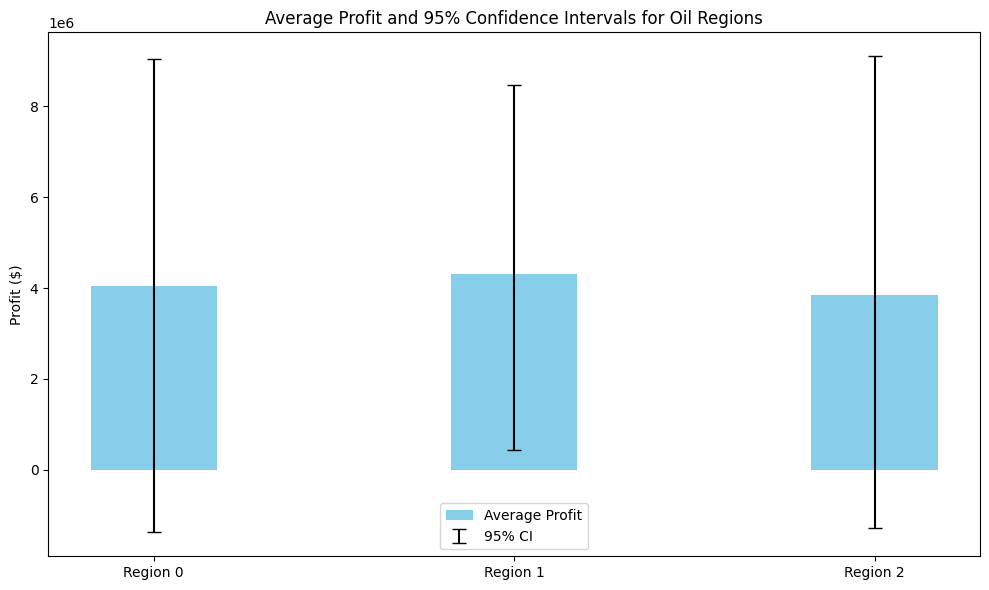

In [17]:
# Graphing a Visual
region_names = [region["name"] for region in regions]
mean_profits = []
profit_risk_lbs = []
profit_risk_ubs = []

# Collecting data for plotting
for region in regions:
    mean_profit, profit_risk_lb, profit_risk_ub, losses = bootstrap_revenue_model(
        region["actual"], region["predicted_reserves"]
    )
    mean_profits.append(mean_profit)
    profit_risk_lbs.append(profit_risk_lb)
    profit_risk_ubs.append(profit_risk_ub)

# Creating the plot
x = np.arange(len(region_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for mean profits
bars = ax.bar(x, mean_profits, width, label='Average Profit', color='skyblue')

# Adding error bars for the confidence intervals
ax.errorbar(x, mean_profits, 
            yerr=[np.array(mean_profits) - np.array(profit_risk_lbs), 
                  np.array(profit_risk_ubs) - np.array(mean_profits)],
            fmt='none', color='black', capsize=5, label='95% CI')

# Adding labels and title
ax.set_ylabel('Profit ($)')
ax.set_title('Average Profit and 95% Confidence Intervals for Oil Regions')
ax.set_xticks(x)
ax.set_xticklabels(region_names)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Conclusion

- Highest Average Profit: Region 1 has the highest average profit of approximately \\$4,302,083.52.

- Narrower Confidence Interval: The 95\% confidence interval for Region 1 ranges from \\$430,525.20 to \\$8,473,134.67. 

- Lowest Risk of Losses: Region 1 has the lowest risk of losses at just 1.60\%.

- Positive Lower Bound: Unlike Region 0 and Region 2, which have negative values in their confidence intervals, Region 1's lower bound is positive, further supporting the decision to focus on this region.

**Given the analysis of average profits, confidence intervals, and risk of losses, Region 1 is the most promising choice for the development of oil wells. It provides the best combination of potential profit and low risk, making it a strategic option for investment in the oil exploration and extraction process.**